In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import time
import os
from datetime import datetime,timedelta
from tqdm.notebook import tqdm
import plotly.graph_objects as go
from pprint import pprint
from currencycom.client import Client

In [2]:
def minute_passed(last_timestamp: datetime, current_timestamp: datetime) -> bool:
    return current_timestamp - last_timestamp >= timedelta(minutes=1)

def hour_passed(last_timestamp: float, current_timestamp: datetime) -> bool:
    return current_timestamp - last_timestamp >= timedelta(hours=1)

def delta_passed(last_timestamp:float, current_timestamp: datetime, delta: timedelta) -> bool:
    return current_timestamp - last_timestamp >= delta

def time_up(current_timestamp: datetime, finish_time: datetime) -> bool:
    return finish_time - current_timestamp <= timedelta()

def get_server_time() -> datetime:
    return datetimify(Client.get_server_time()['serverTime'])

def datetimify(time: str) -> datetime:
    return datetime.fromtimestamp(int(time) * 0.001)

In [10]:
def collect_prices(
    for_: timedelta,
    pair: str = 'BTC/USD',
    save_interval: timedelta = timedelta(hours=1)
) -> None:

    current_time = save_time = start_time = get_server_time()
    prices = []
    print(f'Start time: {start_time}')

    while not delta_passed(start_time, current_time, for_):
        try:
            current_time = get_server_time()
            price_change = Client.get_24h_price_change(pair)
            prices.append({
                'price': float(price_change['lastPrice']),
                'time': datetimify(price_change['closeTime'])
            })

            if delta_passed(save_time, current_time, save_interval):
                save_time = current_time
                filename = f'data/{"_".join(pair.split("/"))}_{save_time.strftime("%y-%m-%d_%H-%M")}_prev{save_interval}.csv'
                pd.DataFrame.from_records(prices).drop_duplicates().to_csv(filename)
                print(f'Saved to {filename}')
                prices = []
        except Exception as e:
            print(e)
        except KeyboardInterrupt:
            break

    save_time = current_time
    filename = f'data/{"_".join(pair.split("/"))}_{save_time.strftime("%y-%m-%d_%H-%M")}_prev{save_interval}.csv'
    pd.DataFrame.from_records(prices).drop_duplicates().to_csv(filename)
    print(f'Saved to {filename}')

In [11]:
def load_prices(data_dir='data'):
    series = []
    for f in os.listdir(data_dir):
        if f.endswith('csv'):
            series.append(pd.read_csv(os.path.join(data_dir, f), index_col=0, parse_dates=['time']))
    return pd.concat(series).drop_duplicates().sort_values('time').reset_index(drop=True)

In [ ]:
collect_prices(for_=timedelta(hours=2), save_interval=timedelta(minutes=30))

Start time: 2021-07-13 10:17:28.569000
Saved to data/BTC_USD_21-07-13_10-47_prev0:30:00.csv


In [99]:
df = load_prices()

<AxesSubplot:xlabel='time'>

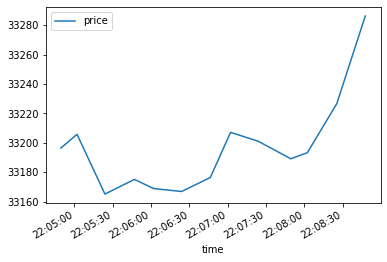

In [101]:
df.plot('time', 'price')